In [30]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
from scipy import sparse
sys.path.append("../spykesim")
import editsim
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
%matplotlib inline

def genpoisson_spiketrain(rate, dt, duration):
    offset = duration
    events = np.cumsum(np.random.exponential(scale = 1 / rate, size = int(duration*rate + offset)))
    return np.round(events[np.logical_and(0 < events, events < duration)], -int(np.log10(dt)))

def genpoisson_spiketrains(nneurons, rate, dt, duration):
    spike_timings = np.array([], dtype = np.float)
    spike_neurons = np.array([], dtype = np.int)
    for n in range(nneurons):
        spike_train = genpoisson_spiketrain(rate, dt, duration)
        spike_timings = np.r_[spike_timings, spike_train]
        spike_neurons = np.r_[spike_neurons, n * np.ones_like(spike_train, dtype = np.int)]
    return pd.DataFrame({
        "neuronid": spike_neurons,
        "spiketime": spike_timings
    })

def gen_sequence(nneurons = 10, seqlen = 0.1, dt = 0.001):
    return np.round(np.linspace(dt, seqlen-dt, nneurons), int(-np.log10(dt)))

def gen_sequences(neurons = np.arange(10), nsequences = 10, start = 0, end = 60, seqlen = 0.1, dt = 0.001, shrink = 1):
    spike_timings = np.array([], dtype = np.float)
    spike_neurons = np.array([], dtype = np.int)
    nneurons = len(neurons)
    sequence_onsets = np.random.choice(
        np.arange(start, end - seqlen, seqlen),
        nsequences,
        replace = False
    )
    for onset in sequence_onsets:
        spike_timings = np.r_[spike_timings, onset + gen_sequence(nneurons, seqlen / shrink, dt)]
        spike_neurons = np.r_[spike_neurons, neurons]
    return pd.DataFrame({
        "neuronid": spike_neurons,
        "spiketime": spike_timings
    }), sequence_onsets

def gen_sequences_with_replay(shrinkages = [2], neurons = np.arange(10),
                              nsequences = 10, duration = 60,
                              seqlen = 0.1, dt = 0.001, seqtype = 1):
    onsets = []
    duration_per_type = duration / (len(shrinkages) + 1)
    sequences, onset = gen_sequences(neurons,
                              nsequences,
                              0,
                              duration_per_type,
                              seqlen,
                              dt)
    onsets.append(onset)
    for idx, shrinkage in enumerate(shrinkages):
        replay, onset = gen_sequences(neurons,
                               nsequences,
                               duration_per_type * (idx + 1),
                               duration_per_type * (idx + 2),
                               seqlen,
                               dt, 
                               abs(shrinkage))
        onsets.append(onset)
        if shrinkage < 0: # reverse replay
            replay = pd.DataFrame({
                "neuronid": replay.neuronid,
                "spiketime": np.copy(replay.spiketime[::-1])
            })
        sequences = pd.concat([sequences, replay])
    return sequences, onsets

In [31]:
dt = 0.001
# nsequences = 10
# seqlen = 0.3
nsequences = 5
seqlen = 0.1
shrinkages = [-5, 5]
nneurons = 10
duration = nsequences * seqlen * (len(shrinkages) + 1) + 0.2
nseqkinds = 3
df = pd.DataFrame()
onsets = []
for idx in range(nseqkinds):
    df_seq, onset = gen_sequences_with_replay(
        shrinkages = shrinkages,
        neurons = np.arange(nneurons*(idx), nneurons*(idx+1)),
        nsequences = nsequences,
        duration = duration,
        seqlen = seqlen,
        dt = dt)
    onsets.append(onset)
    df_seq = pd.DataFrame({
        "neuronid": df_seq.neuronid,
        "spiketime": np.copy(df_seq.spiketime + duration * idx + idx)
    })
    df = pd.concat([df, df_seq])

rate = 1
nneurons = nneurons*nseqkinds 
duration = duration*nseqkinds + nseqkinds
df_noise = genpoisson_spiketrains(nneurons, rate, dt, duration)
df = pd.concat([df, df_noise])

In [32]:
onsets

[[array([ 0.2,  0.1,  0. ,  0.3,  0.4]),
  array([ 0.66666667,  0.86666667,  0.76666667,  0.56666667,  0.96666667]),
  array([ 1.33333333,  1.23333333,  1.13333333,  1.43333333,  1.53333333])],
 [array([ 0. ,  0.2,  0.3,  0.4,  0.1]),
  array([ 0.66666667,  0.76666667,  0.96666667,  0.56666667,  0.86666667]),
  array([ 1.23333333,  1.13333333,  1.43333333,  1.53333333,  1.33333333])],
 [array([ 0. ,  0.3,  0.2,  0.1,  0.4]),
  array([ 0.66666667,  0.76666667,  0.96666667,  0.56666667,  0.86666667]),
  array([ 1.33333333,  1.23333333,  1.13333333,  1.43333333,  1.53333333])]]

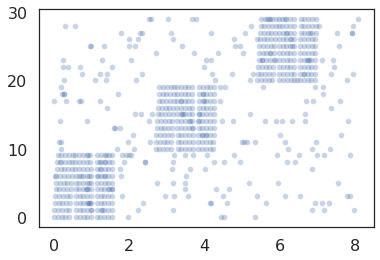

In [3]:
plt.plot(df.spiketime, df.neuronid, "b.", alpha = 0.3)

In [4]:
def df2binarray_csc(df, duration_ms = int(df.spiketime.max()*1000), binwidth = 1):
    neuronids = df.neuronid
    spikes_ms = df.spiketime * 1000
    nneurons = int(neuronids.max()+1)
    nrow = nneurons 
    ncol = int(duration_ms) // binwidth + 1000
    binarray_lil = sparse.lil_matrix((nrow, ncol))
    for neuronid in range(nneurons):
        spike_train_of_a_neuron = spikes_ms[neuronids == neuronid]
        bins = np.arange(0, ncol * binwidth, binwidth)
        digitized_spike_train_of_a_neuron = np.digitize(spike_train_of_a_neuron, bins) - 1
        binned_spike_train_of_a_neuron = np.bincount(digitized_spike_train_of_a_neuron)
        binarray_lil[neuronid, digitized_spike_train_of_a_neuron] = binned_spike_train_of_a_neuron[digitized_spike_train_of_a_neuron]
    return binarray_lil.tocsc()

In [5]:
from matplotlib import gridspec

binarray_csc = df2binarray_csc(df, duration_ms=int(duration*1000), binwidth = 1)
binmat = binarray_csc.toarray()

In [6]:
window = int(seqlen*1000)
a = 0.01
simmat, times = editsim.eval_simmat(binarray_csc, window, window, a = a, backend = "tqdm")

[2018-07-24 17:52:31,343] [MainThread] calculation start
[2018-07-24 17:52:33,534] [MainThread] submit end
[2018-07-24 17:52:33,547] [MainThread] Progress of the calculation
100%|██████████| 88.0/88.0 [00:03<00:00, 24.2it/s]
[2018-07-24 17:52:37,233] [MainThread] Progress of the aggregation
88it [00:00, 148830.14it/s]
[2018-07-24 17:52:37,236] [MainThread] calculation end


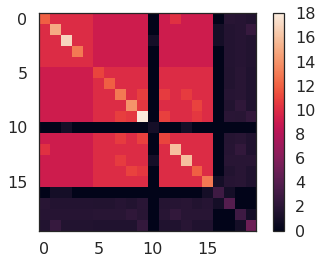

In [7]:
plt.imshow(simmat[:20, :20])
plt.colorbar()

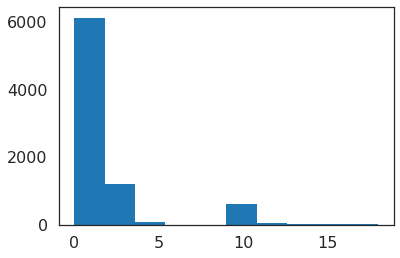

In [8]:
plt.hist(simmat.flatten());

In [9]:
th_ = np.percentile(simmat, 50)

In [10]:
X = []
Y = []
for idx1, t1 in enumerate(times):
    for idx2, t2 in enumerate(times):
        mat1 = binarray_csc[:, t1:t1+window].toarray()
        mat2 = binarray_csc[:, t2:t2+window].toarray()
        X.append([mat1, mat2])
        tmp = 1 if simmat[idx1, idx2] >= th_ else 0
        Y.append(1 if simmat[idx1, idx2] >= th_ else 0)
X = np.array(X)
Y = np.array(Y)

In [11]:
one_indices = np.where(np.array(Y) == 1)[0]
mask = np.zeros(Y.shape, dtype = bool)
mask[one_indices] = True
Y_one = Y[mask]
Y_none = Y[~mask]
X_one = X[mask]
X_none = X[~mask]

In [12]:
X_one.shape

(4246, 2, 30, 100)

In [13]:
ndata = 100
X_ = np.r_[X_one[:ndata], X_none[:ndata]]
Y_ = np.r_[Y_one[:ndata], Y_none[:ndata]]

In [14]:
from sklearn.model_selection import train_test_split
X_train_, X_test_, Y_train_, Y_test_ = train_test_split(X_, Y_, test_size = 0.2)

In [15]:
xt_mean = np.mean(X_train_)
xt_std = np.std(X_train_)
yt_mean = np.mean(Y_train_)
yt_std = np.std(Y_train_)

X_train = (X_train_ - xt_mean) / xt_std
X_test = (X_test_ - xt_mean) / xt_std
Y_train = Y_train_
Y_test = Y_test_
# Y_train = (Y_train_ - yt_mean) / yt_std
# Y_test = (Y_test_ - yt_mean) / yt_std

In [16]:
model = __import__('siamse')

In [17]:
import tensorflow as tf

In [18]:
tf.reset_default_graph()
snn = model.SNN(30, 10, 5, window)
history = snn.fit(X_train, Y_train,
                  X_test, Y_test,
                  epochs = 100, batch_size = 10, p_keep = .8, every=10)

epoch: 0, loss: 0.12049295753240585
test epoch: 0, loss: 0.1337355077266693
epoch: 10, loss: 0.020123349502682686
test epoch: 10, loss: 0.04957849532365799
epoch: 20, loss: 0.013928065076470375
test epoch: 20, loss: 0.06362535804510117
epoch: 30, loss: 0.013200351968407631
test epoch: 30, loss: 0.09049796313047409
epoch: 40, loss: 0.013160315342247486
test epoch: 40, loss: 0.07220706343650818
epoch: 50, loss: 0.011479870416224003
test epoch: 50, loss: 0.082292839884758
epoch: 60, loss: 0.014131957665085793
test epoch: 60, loss: 0.07252872735261917
epoch: 70, loss: 0.021659107878804207
test epoch: 70, loss: 0.08227815479040146
epoch: 80, loss: 0.014637613669037819
test epoch: 80, loss: 0.06493449211120605
epoch: 90, loss: 0.014344178140163422
test epoch: 90, loss: 0.083035409450531


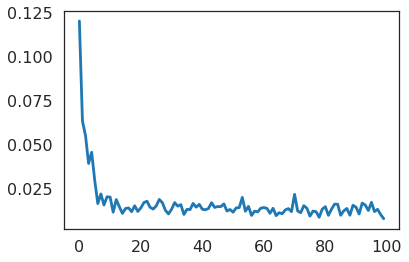

In [19]:
plt.plot(history["loss"])

In [20]:
snn.predict(X_test) 

array([  7.23395497e-04,  -9.68769610e-01,  -8.75346005e-01,
         9.46349978e-01,   7.32837617e-01,  -5.37260056e-01,
        -7.00023174e-01,   7.86396921e-01,   8.79526198e-01,
        -7.00888753e-01,  -6.11674249e-01,  -6.58795714e-01,
         7.32659578e-01,   1.93670958e-01,   8.19236398e-01,
         9.17377710e-01,   8.86592388e-01,   5.32700360e-01,
         8.82362604e-01,   9.88994002e-01,   7.64666140e-01,
        -4.83058274e-01,  -9.50513959e-01,  -9.07946527e-01,
        -7.24597931e-01,   7.20839560e-01,  -8.73161256e-01,
        -6.33739650e-01,  -5.72105527e-01,  -7.61421382e-01,
        -7.45954871e-01,  -6.14504695e-01,   9.89845753e-01,
        -8.82304788e-01,   6.30273223e-01,  -4.80464041e-01,
        -6.32665515e-01,   9.93112385e-01,  -8.91416192e-01,
        -8.62909436e-01], dtype=float32)

In [24]:
X = np.array([x[0] for x in X_train])

In [25]:
embedding = snn.embed(X)

In [26]:
embedding.shape

(160, 5)

In [28]:
X_train.shape

(160, 2, 30, 100)

In [29]:
embedding.shape

(160, 5)